In [ ]:
!pip install zarr
!pip install -U xarray

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%load_ext autoreload
%autoreload 2

# from model import spatial_feature_pyramid_net_hiddenstate_ND, spatial_feature_pyramid_net_vectorized_ND
import xarray as xr
import zarr
import pandas as pd
from functools import partial
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.regularizers import L1L2
from functools import partial

import sys
sys.path.append('/content/drive/MyDrive/syde770/amrakesh28')

from encoder_decoder import EncoderDecoder

from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
output_notebook()

def split_time(ds, test_size):
    idx = int(len(ds.time) * (1 - test_size))
    train, test = ds.isel(time=slice(None, idx)), ds.isel(time=slice(idx, None))
    return train, test

def fake_loss(y_true, y_pred):
    print(y_pred.shape)
    print(y_true.shape)
    return 0

def apply_tresh(arr, thresh=85, ones_are_open_water=True):
  arr_thresh = np.zeros_like(arr)
  if ones_are_open_water:
      arr_thresh[arr < thresh] = 1
  else:
      arr_thresh[arr > thresh] = 1
  arr_thresh[np.isnan(arr)] = np.nan
  return arr_thresh

def masked_MSE(mask):
    def loss(y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        sq_diff = tf.multiply(tf.math.squared_difference(y_pred, y_true), mask)
        return tf.reduce_mean(sq_diff)
    return loss

def masked_MAE(mask):
    def loss(y_true, y_pred):
        y_pred = tf.convert_to_tensor(y_pred)
        y_true = tf.cast(y_true, y_pred.dtype)
        ab_diff = tf.multiply(tf.math.abs(tf.math.subtract(y_pred, y_true)), mask)
        return tf.reduce_mean(ab_diff)
    return loss

def iiee(y_true, y_pred, thresh=0.85, nan_mask=None):
    # Apply thresh
    y_true = tf.maximum(tf.sign(y_true - thresh), 0)
    y_pred = tf.maximum(tf.sign(y_pred - thresh), 0)
    
    # Apply land mask
    if nan_mask is not None:
        y_true = tf.multiply(y_true, ~nan_mask)
        y_pred = tf.multiply(y_pred, ~nan_mask)
    
    # Calculate IIEE
    diff = tf.subtract(y_true, y_pred)
    o = tf.reduce_sum(tf.math.maximum(diff, 0))
    i = tf.reduce_sum(tf.math.maximum(diff * -1, 0))
    return o + i

## Pre-process

In [4]:
test_size = 0.3
deseasonalize = False
only_winter = True
weekly = True
binary_sic = False
only_polynya = True

def is_winter(month):
    return (month >= 1) & (month < 5)

# Read and drop unnecessary variables
ds = xr.open_zarr('/content/drive/MyDrive/syde770/data.zarr')
ds = ds.drop(['Lambert_Azimuthal_Grid', 'status_flag', 'ceda_sic_bin', 'era5_sic', 'era5_sic_bin', 'total_standard_error'])

if weekly:
    ds = ds.resample(time='W').mean()

# Split by time into train & test
train, test = split_time(ds, test_size)

# Include only winter, if desired
if only_winter:
    train = train.sel(time=is_winter(train['time.month']))
    test = test.sel(time=is_winter(test['time.month']))

if only_polynya:
    train = train.isel(x=slice(30, 54), y=slice(2, 22))
    test = test.isel(x=slice(30, 54), y=slice(2, 22))
    
unscaled_sic_train, unscaled_sic_test = train.ceda_sic.values, test.ceda_sic.values

# Deseasonalize, if desired
if deseasonalize:
    climatologies = train.groupby('time.dayofyear').mean()
    train = train.groupby('time.dayofyear') - climatologies
    test = test.groupby('time.dayofyear') - climatologies

# Transform into np.array
train_array, test_array = train.to_array().to_numpy(), test.to_array().to_numpy()

# Apply (pseudo-)landmask
nan_mask = np.isnan(train_array[0][0])

# Scaling
scaler = StandardScaler()
train_array = scaler.fit_transform(train_array.reshape(-1, np.prod(train_array.shape[1:])).T).T.reshape(train_array.shape)
test_array = scaler.transform(test_array.reshape(-1, np.prod(test_array.shape[1:])).T).T.reshape(test_array.shape)

if binary_sic:
    train_array[0] = apply_tresh(unscaled_sic_train, 85).astype(int)
    test_array[0] = apply_tresh(unscaled_sic_test, 85).astype(int)
        
# Replace NaNs with 0s 
train_array, test_array = np.nan_to_num(train_array), np.nan_to_num(test_array)

/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)
/usr/local/lib/python3.7/dist-packages/dask/array/numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


In [5]:
# Create timesteps
num_timesteps = 4
num_timesteps_predict = 1
gap = 0

predict_only_sic = True

def create_timesteps(arr, num_timesteps=3):
    timesteps = [arr[:-(num_timesteps - 1)]]
    
    for i in range(1, num_timesteps - 1):
        timesteps.append(arr[i:-((num_timesteps-1)-i)])
                 
    timesteps.append(arr[(num_timesteps - 1):])
    return np.array(timesteps)

train_X = np.transpose(train_array, axes=[1, 2, 3, 0])
train_X = create_timesteps(train_X, num_timesteps + gap + num_timesteps_predict)
train_X = np.transpose(train_X, axes=[1, 0, 2, 3, 4])

test_X = np.transpose(test_array, axes=[1, 2, 3, 0])
test_X = create_timesteps(test_X, num_timesteps + gap + num_timesteps_predict)
test_X = np.transpose(test_X, axes=[1, 0, 2, 3, 4])

# Split x and y
train_Y = train_X[:, -(num_timesteps_predict):, :, :, :]  # 0th variable is SIC
test_Y = test_X[:, -(num_timesteps_predict):, :, :, :]  # 0th variable is SIC

train_X = train_X[:, :num_timesteps, :, :, :]
test_X = test_X[:, :num_timesteps, :, :, :]

dates_train = train.time[num_timesteps + gap:]
dates_test = test.time[num_timesteps + gap:]

if predict_only_sic:
    train_Y = np.expand_dims(train_Y[..., 0], -1)
    test_Y = np.expand_dims(test_Y[..., 0], -1)

print(f'{train_X.shape}')
print(f'{train_Y.shape}')
print(f'{test_X.shape}')
print(f'{test_Y.shape}')

(105, 4, 20, 24, 6)
(105, 1, 20, 24, 1)
(42, 4, 20, 24, 6)
(42, 1, 20, 24, 1)


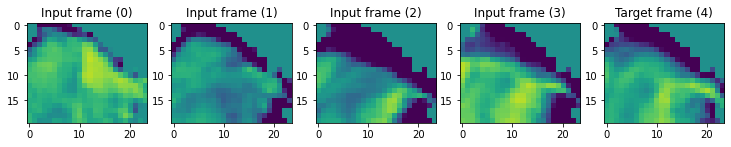

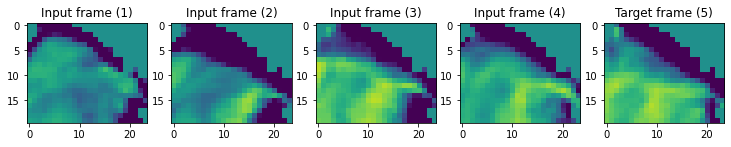

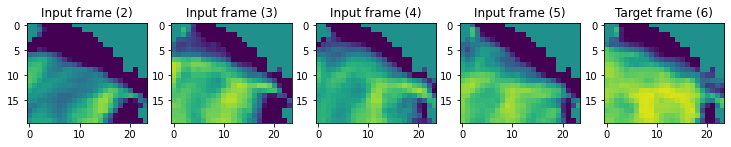

In [6]:
num_samples = 3
for i in range(num_samples):
    fig, axs = plt.subplots(1, num_timesteps + num_timesteps_predict, figsize=(2.5 * (num_timesteps + num_timesteps_predict), 4))
    
    for j in range(len(train_X[i])):
        axs[j].imshow(train_X[i][j][..., 0], vmin=-1, vmax=1)
        axs[j].set_title(f'Input frame ({i + j})')
        
    for k in range(len(train_Y[i])):
        axs[j + 1 + k].imshow(train_Y[i][k][..., 0], vmin=-1, vmax=1)
        axs[j + 1 + k].set_title(f'Target frame ({i + j + gap + 1 + k})')

    plt.show()

## Spatial prediction

In [ ]:
# From amrakesh28
amrakesh = EncoderDecoder(
        num_layers=2, 
        unit_list=[64, 48], 
        filter_sz=[(3, 3), (3, 3)], 
        batch_sz=10, 
        image_sz=(train_X.shape[2], train_X.shape[3], train_X.shape[4]),
        checkpoint_dir='./training_checkpoints',
        loss=masked_MSE(np.expand_dims(~nan_mask, [0, -1])),
)

# amrakesh.train(inputX=train_X,
#             targetY=train_Y,
#             epochs=1000,
#             valX=test_X,
#             valY=test_Y)

In [7]:
class Persistence:
    def __init__(self):
        pass
    
    def predict(self, X):
        """X.shape: (num_features, timesteps, x, y, features) where features[0] is siconc"""
        return X[:, -1:, :, :, 0:1]

class Climatology:
    def __init__(self):
        pass

    def fit(self, y, dates):
        self.climatologies = xr.DataArray(
            y[:, 0, :, :, 0],
            dims=['time', 'y', 'x'],
            coords={'time': dates_train}
            ).groupby('time.month').mean()
        
    def predict(self, dates):
        pred_y = xr.DataArray(np.zeros(shape=len(dates)), coords={'time': dates}).groupby('time.month') + self.climatologies
        return np.expand_dims(pred_y.to_numpy(), [1, -1])

In [32]:
# Construct the input layer with no definite frame size.
inp = layers.Input(shape=(num_timesteps, *train_X.shape[2:]))
print(inp.shape)

last_day = inp[:, -1:, ..., :1]
x = inp[..., 1:]

# Stacked ConvLSTM layers
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
    dropout=0.1,
    recurrent_dropout=0.1,
    # kernel_regularizer=L1L2(0.001, 0.01),
    name='ConvLSTM1'
)(x)
x = layers.BatchNormalization(name='BN1')(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=False,
    activation="relu",
    dropout=0.1,
    recurrent_dropout=0.1,
    kernel_regularizer=L1L2(0.001, 0.001),
    name='ConvLSTM2'
)(x)
# x = layers.BatchNormalization(name='BN2')(x)
# x = layers.ConvLSTM2D(
#     filters=64,
#     kernel_size=(3, 3),
#     padding="same",
#     return_sequences=False,
#     activation="relu",
#     dropout=0.1,
#     recurrent_dropout=0.1,
#     # kernel_regularizer=L1L2(0.001, 0.01),
#     name='ConvLSTM3'
# )(x)

x = tf.expand_dims(x, 1, name='Reshape')  # Reshape to get the 1 timestep

# Convolutions to reduce the number of channels
x = layers.Conv2D(
    filters=64,
    kernel_size=(5, 5),
    activation='relu',
    padding='same',
    name='Conv2D1'
)(x)

x = layers.Conv2D(
    filters=64,
    kernel_size=(3, 3),
    activation='relu',
    padding='same',
    name='Conv2D2'
)(x)

x = layers.Conv2D(
    filters=64,
    kernel_size=(1, 1),
    activation='relu',
    padding='same',
    name='Conv2D3'
)(x)

# x = layers.Conv2D(
#     filters=12,
#     kernel_size=(3, 3),
#     activation='relu',
#     padding='same',
#     name='Conv2D2'
# )(x)

# Append the last day
# last_day = layers.Cropping3D(
#     cropping=((num_timesteps - 1, 0), (0, 0), (0, 0)),
#     name='get_lastday'
# )(inp)

# last_day = layers.Cropping3D(
#     cropping=((0, 0), (0, 0), (0, 5)),
#     data_format='channels_first',
#     name='get_SIC'
# )(last_day)  # Get first variable (siconc)

# Concatenate the output from the stacked ConvLSTMs and the last day
x = layers.concatenate([x, last_day], axis=-1, name='Concat')

# Convolutions to reduce the number of channels
x = layers.Conv2D(
    filters=1,
    kernel_size=(1, 1),
    # activation="relu",
    padding="same",
    use_bias=False,
    name='Conv2D_out',
)(x)

if binary_sic:
    loss = tf.keras.losses.MeanSquaredError()
    # loss = tf.keras.losses.BinaryCrossentropy()
else:
    # loss = iiee
    loss = masked_MSE(mask=np.expand_dims(~nan_mask, [0, -1]))
    # loss = tf.keras.losses.MeanSquaredError()

model = keras.models.Model(inp, x)
# model.compile(loss=fake_loss, optimizer='adam')
model.compile(loss=loss, optimizer=keras.optimizers.Adam(learning_rate=0.01))
model.summary()

# Set initial weights of last layer
# init_last_weights = np.zeros_like(model.layers[-1].weights[0])
# init_last_weights[0, 0, -1, 0] = 1
# model.layers[-1].set_weights([init_last_weights, np.array([0])])

(None, 4, 20, 24, 6)
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 4, 20, 24,   0           []                               
                                6)]                                                               
                                                                                                  
 tf.__operators__.getitem_18 (S  (None, 4, 20, 24, 5  0          ['input_15[0][0]']               
 licingOpLambda)                )                                                                 
                                                                                                  
 ConvLSTM1 (ConvLSTM2D)         (None, 4, 20, 24, 6  441856      ['tf.__operators__.getitem_18[0][
                                4)                               0]']  

In [33]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 500
batch_size = 20

# Train
history = model.fit(
    train_X,
    train_Y,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(test_X, test_Y),
    callbacks=[early_stopping, reduce_lr],
    # verbose=0,
)

Epoch 1/500
6/6 [==============================] - 7s 215ms/step - loss: 384.6592 - val_loss: 132.7932 - lr: 0.0100
Epoch 2/500
6/6 [==============================] - 1s 101ms/step - loss: 5.5281 - val_loss: 1260.4576 - lr: 0.0100
Epoch 3/500
6/6 [==============================] - 1s 97ms/step - loss: 6.9803 - val_loss: 16.6899 - lr: 0.0100
Epoch 4/500
6/6 [==============================] - 1s 97ms/step - loss: 7.6994 - val_loss: 15.7498 - lr: 0.0100
Epoch 5/500
6/6 [==============================] - 1s 105ms/step - loss: 8.1597 - val_loss: 13.4606 - lr: 0.0100
Epoch 6/500
6/6 [==============================] - 1s 96ms/step - loss: 8.2761 - val_loss: 8.8315 - lr: 0.0100
Epoch 7/500
6/6 [==============================] - 1s 98ms/step - loss: 8.3346 - val_loss: 10.0319 - lr: 0.0100
Epoch 8/500
6/6 [==============================] - 1s 99ms/step - loss: 8.3266 - val_loss: 8.4758 - lr: 0.0100
Epoch 9/500
6/6 [==============================] - 1s 97ms/step - loss: 8.2648 - val_loss: 8.7462 

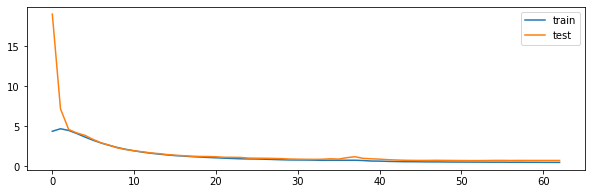

In [27]:
plt.figure(figsize=(10, 3))
plt.plot(history.history['loss'][1:], label='train')
plt.plot(history.history['val_loss'][1:], label='test')
plt.legend()
plt.show()

In [34]:
nan_mask_reshaped = np.expand_dims(~nan_mask, [0, -1])
df = pd.DataFrame(index=['Train MAE', 'Train MSE', 'Test MAE', 'Test MSE'])

results = {}

# NN
results['NN'] = {}
results['NN']['Train'] = model.predict(train_X)
results['NN']['Test'] = model.predict(test_X)

# Persistence
results['Persistence'] = {}
results['Persistence']['Train'] = Persistence().predict(train_X)
results['Persistence']['Test'] = Persistence().predict(test_X)

# Climatology
clim = Climatology()
clim.fit(train_Y, dates_train)
results['Climatology'] = {}
results['Climatology']['Train'] = clim.predict(dates_train)
results['Climatology']['Test'] = clim.predict(dates_test)


for model_name, scores in results.items():
  df[model_name] = [
    masked_MAE(nan_mask_reshaped)(train_Y, scores['Train']).numpy(),
    masked_MSE(nan_mask_reshaped)(train_Y, scores['Train']).numpy(),
    masked_MAE(nan_mask_reshaped)(test_Y, scores['Test']).numpy(),
    masked_MSE(nan_mask_reshaped)(test_Y, scores['Test']).numpy(),
  ]
  
df.round(3)

,NN,Persistence,Climatology
Train MAE,0.349,0.407,0.368
Train MSE,0.397,0.586,0.426
Test MAE,0.434,0.447,0.506
Test MSE,0.565,0.677,0.706


In [35]:
import tqdm
import random
def shuffle_ndarray(arr):
    arr_shape = arr.shape

    arr = arr.flatten()
    random.shuffle(arr)
    return arr.reshape(arr_shape)

def shuffle_along_dim(arr, i, axis=0):
    arr_i = shuffle_ndarray(np.moveaxis(arr, axis, 0)[i])
    arr = np.moveaxis(arr, axis, 0)
    arr[i] = arr_i
    arr = np.moveaxis(arr, 0, axis)
    return arr

# List of test_X where each variable is shuffled 
rmses = []
for i in tqdm.tqdm(range(10)):
    test_X_shuffled = [shuffle_along_dim(test_X.copy(), i, axis=-1) for i in range(6)]

    # Test each one
    rmses_i = []
    for test_X0 in [test_X] + test_X_shuffled:
        pred = model.predict(test_X0)
        nan_mask_reshaped = np.expand_dims(~nan_mask, [0, -1])

        mse = masked_MSE(nan_mask_reshaped)(
            test_Y,
            pred).numpy()
        rmses_i.append(np.sqrt(mse))

    rmses.append(rmses_i)

rmses = np.array(rmses).mean(axis=0)
diff = [(rmse - rmses[0]).round(3) for rmse in rmses]
print(diff)

100%|██████████| 10/10 [00:10<00:00,  1.06s/it]

[0.0, 0.231, 0.002, 0.003, 0.001, 0.016, -0.017]


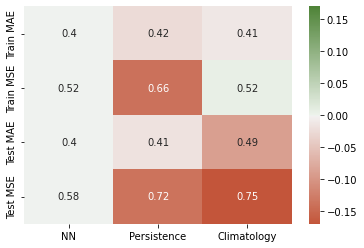

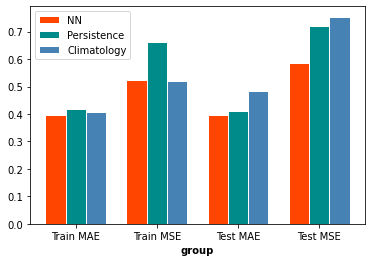

In [ ]:
# HEATMAP ----------------------------------------------------------------------
diff = df.sub(df['NN'], axis=0) * -1
sns.heatmap(diff,
            annot=df,
            cmap=sns.diverging_palette(20, 120, as_cmap=True),
            vmin=-np.abs(diff.to_numpy().flatten()).max(),
            vmax=np.abs(diff.to_numpy().flatten()).max(),
            center=0)
plt.show()

# BARPLOT ----------------------------------------------------------------------
# set width of bars
barWidth = 0.25
 
# set heights of bars
bars1 = df['NN']
bars2 = df['Persistence']
bars3 = df['Climatology']
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, bars1, color='orangered', width=barWidth, edgecolor='white', label='NN')
plt.bar(r2, bars2, color='darkcyan', width=barWidth, edgecolor='white', label='Persistence')
plt.bar(r3, bars3, color='steelblue', width=barWidth, edgecolor='white', label='Climatology')
 
# Add xticks on the middle of the group bars
plt.xlabel('group', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(bars1))], ['Train MAE', 'Train MSE', 'Test MAE', 'Test MSE'])
 
# Create legend & Show graphic
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/syde770/FBP')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/syde770/FBP/assets


In [ ]:
mean_absolute_error(Persistence().predict(train_X).flatten(), model.predict(train_X).flatten())

0.33509134904097115

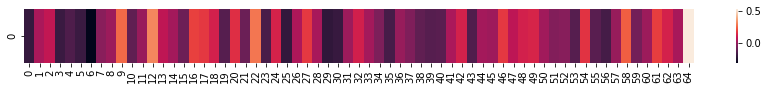

In [36]:
plt.figure(figsize=(15, 1))
sns.heatmap(model.layers[-1].weights[0].numpy()[0][0].T)

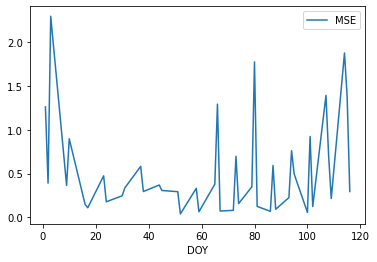

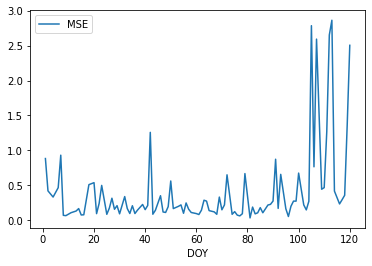

In [ ]:
MSE_df = pd.DataFrame({
  'MSE': [masked_MSE(nan_mask_reshaped)(t, p).numpy() for t, p in zip(test_Y, results['NN']['Test'])]
}, index=dates_test)
MSE_df['DOY'] = MSE_df.index.day_of_year
MSE_df = MSE_df.groupby('DOY').mean()

MSE_df.plot()

MSE_df = pd.DataFrame({
  'MSE': [masked_MSE(nan_mask_reshaped)(t, p).numpy() for t, p in zip(train_Y, results['NN']['Train'])]
}, index=dates_train)
MSE_df['DOY'] = MSE_df.index.day_of_year
MSE_df = MSE_df.groupby('DOY').mean()

MSE_df.plot()

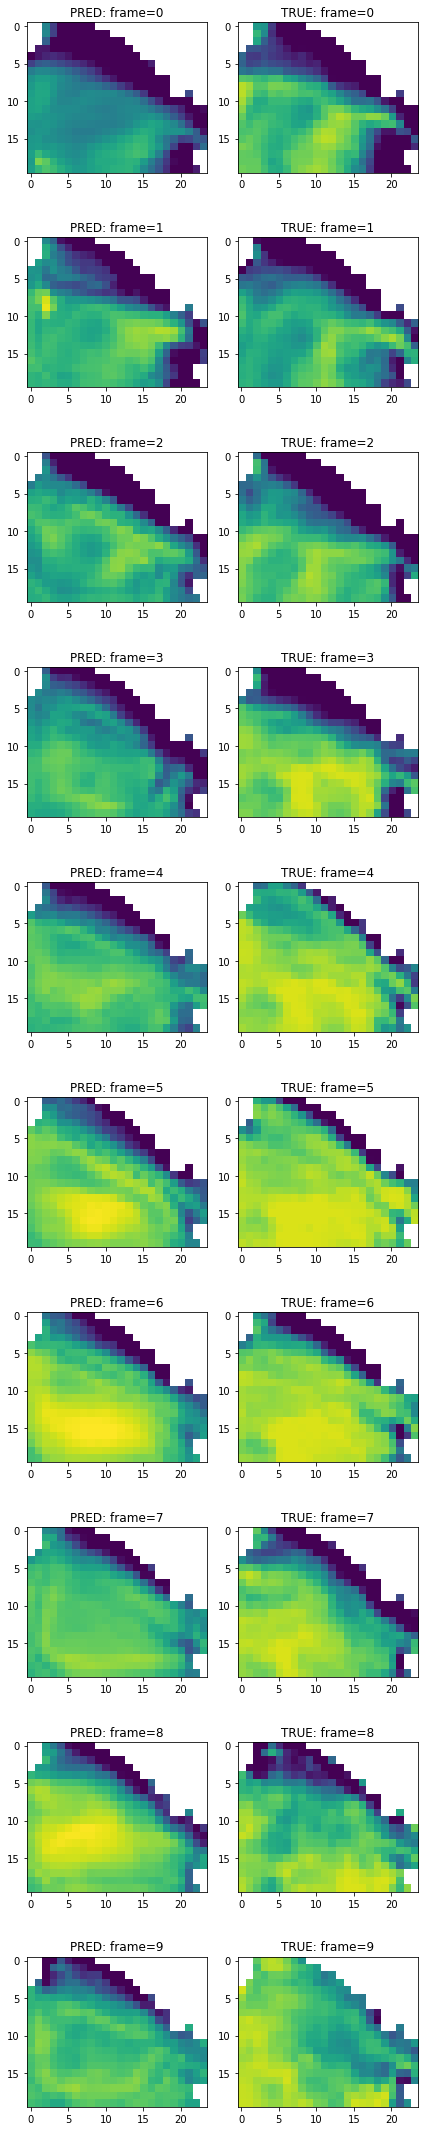

In [ ]:
num_frames = 10
i_start = 0
set_ = 'train'

# model_to_test = Persistence()
model_to_test = model

if set_ == 'train':
    pred = model_to_test.predict(train_X[i_start:i_start + num_frames])
    tru = train_Y[i_start:i_start + num_frames]
elif set_ == 'test':
    pred = model_to_test.predict(test_X[i_start:i_start + num_frames])
    tru = test_Y[i_start:i_start + num_frames]

fig, axs = plt.subplots(num_frames, 2, figsize=(6, num_frames * 3))

for j in range(num_frames):
    axs[j][0].imshow(np.ma.masked_where(nan_mask, pred[j, 0, :, :, 0]), vmin=-1, vmax=1)
    axs[j][0].set_title(f'PRED: frame={j}')
    axs[j][1].imshow(np.ma.masked_where(nan_mask, tru[j, 0, :, :, 0]), vmin=-1, vmax=1)
    axs[j][1].set_title(f'TRUE: frame={j}')
        
plt.tight_layout()

In [ ]:
pred[j - 1, 0, :, :, 0]

array([[0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       ...,
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5]], dtype=float32)

# EXTENT

In [ ]:
X_extents.shape

(106, 3, 1)

In [ ]:
class Persistence:
    def __init__(self):
        pass
    
    def predict(self, X):
        """X.shape: (num_features, timesteps, x, y, features) where features[0] is siconc"""
        return X[:, -1:, 0]


class Climatology:
    def __init__(self):
        pass

    def fit(self, y, dates):
        self.climatologies = xr.DataArray(
            y[:, 0, :, :, 0],
            dims=['time', 'y', 'x'],
            coords={'time': dates_train}
            ).groupby('time.month').mean()
        
    def predict(self, dates):
        pred_y = xr.DataArray(np.zeros(shape=len(dates)), coords={'time': dates}).groupby('time.month') + self.climatologies
        return np.expand_dims(pred_y.to_numpy(), [1, -1])


# Construct the input layer with no definite frame size.
inp = layers.Masking()(layers.Input(shape=(num_timesteps, *train_X.shape[2:])))
extent_inp = layers.Input(shape=(num_timesteps, 1))

# We will construct 3 `ConvLSTM2D` layers with batch normalization,
# followed by a `Conv3D` layer for the spatiotemporal outputs.
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
    # dropout=0.2,
)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
    # dropout=0.2,
)(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=False,
    activation="relu",
    # dropout=0.2,
)(x)
x = layers.Conv2D(
    filters=1, kernel_size=(3, 3), activation="relu", padding="same", data_format='channels_last',
)(x)
# x = layers.Permute((4, 2, 3, 1))(x)
# x = layers.Conv3D(
#     filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same", data_format='channels_last',
# )(x)
shape = [tf.shape(x)[k] for k in range(4)]
x = tf.reshape(x, [shape[0], shape[1]*shape[2]*shape[3]])  # Flattens

# LSTMify the input extents
x_extent = layers.LSTM(64, return_sequences=True)(extent_inp)
x_extent = layers.LSTM(32, return_sequences=True)(x_extent)
x_extent = layers.LSTM(1, return_sequences=False)(x_extent)

x = layers.Dense(64, activation='relu')(x)
x = layers.Concatenate(axis=-1)([x, x_extent])
x = layers.Dense(1)(x)

# Next, we will build the complete model and compile it.
model = keras.models.Model([inp, extent_inp], x)
model.compile(loss='mean_squared_error', optimizer='adam')
# model.compile(loss=fake_loss, optimizer='adam')
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_26 (InputLayer)          [(None, 3, 20, 24,   0           []                               
                                6)]                                                               
                                                                                                  
 conv_lstm2d_24 (ConvLSTM2D)    (None, 3, 20, 24, 6  448256      ['input_26[0][0]']               
                                4)                                                                
                                                                                                  
 batch_normalization_16 (BatchN  (None, 3, 20, 24, 6  256        ['conv_lstm2d_24[1][0]']         
 ormalization)                  4)                                                          

In [ ]:
def apply_tresh(arr, thresh=85):
    arr_thresh = np.zeros_like(arr)
    arr_thresh[arr < thresh] = 1
    arr_thresh[np.isnan(arr)] = np.nan
    return arr_thresh

def get_extent(arr, thresh=85):
    arr_thresh = apply_tresh(arr, thresh)
    return np.nansum(arr_thresh)

deseasonalize = False

if only_polynya:
    y_extents = np.array(list(map(partial(get_extent, thresh=85), unscaled_sic_train)))
    y_extents_test = np.array(list(map(partial(get_extent, thresh=85), unscaled_sic_test)))
else:
    y_extents = np.array(list(map(partial(get_extent, thresh=85), unscaled_sic_train[:, 2:22, 30:54])))
    y_extents_test = np.array(list(map(partial(get_extent, thresh=85), unscaled_sic_test[:, 2:22, 30:54])))

if deseasonalize:
    climatologies = xr.DataArray(y_extents, coords={'time': dates_train}).groupby('time.month').mean()
    y_extents = (xr.DataArray(y_extents, coords={'time': dates_train}).groupby('time.month') - climatologies).values
    y_extents_test = (xr.DataArray(y_extents_test, coords={'time': dates_test}).groupby('time.month') - climatologies).values

extent_scaler = StandardScaler()
y_extents = extent_scaler.fit_transform(y_extents.reshape(-1, 1))
y_extents_test = extent_scaler.transform(y_extents_test.reshape(-1, 1))

# Create it the same way we did the x data (i.e. use timesteps + 1 and use the all but the last entry as the X)
tmp = create_timesteps(y_extents, num_timesteps + 1)
y_extents, X_extents  = np.expand_dims(tmp[-1], 0), tmp[:-1]
tmp = create_timesteps(y_extents_test, num_timesteps + 1)
y_extents_test, X_extents_test  = np.expand_dims(tmp[-1], 0), tmp[:-1]

# Flip axes
X_extents, y_extents = np.transpose(X_extents, axes=[1, 0, 2]), np.transpose(y_extents, axes=[1, 0, 2])
X_extents_test, y_extents_test = np.transpose(X_extents_test, axes=[1, 0, 2]), np.transpose(y_extents_test, axes=[1, 0, 2])

# Depr. ---------
# X_extents, y_extents = y_extents[num_timesteps:-2]
# X_extents_test, y_extents_test = y_extents_test[num_timesteps:-2]
# y_extents = y_extents[num_timesteps + 1:-1]
# y_extents_test = y_extents_test[num_timesteps + 1:-1]
# -----------------

print(train_X.shape)
print(X_extents.shape)
print(y_extents.shape)

print(test_X.shape)
print(X_extents_test.shape)
print(y_extents_test.shape)

(347, 3, 20, 24, 6)
(347, 3, 1)
(347, 1, 1)
(148, 3, 20, 24, 6)
(148, 3, 1)
(148, 1, 1)


In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 10
batch_size = 50

# Fit the model to the training data.
model.fit(
    [train_X, X_extents],
    y_extents,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=([test_X, X_extents_test], y_extents_test),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/10
7/7 [==============================] - 13s 239ms/step - loss: 1.2656 - val_loss: 2.3463 - lr: 0.0010
Epoch 2/10
7/7 [==============================] - 1s 129ms/step - loss: 0.2451 - val_loss: 2.2532 - lr: 0.0010
Epoch 3/10
7/7 [==============================] - 1s 124ms/step - loss: 0.1242 - val_loss: 2.1633 - lr: 0.0010
Epoch 4/10
7/7 [==============================] - 1s 121ms/step - loss: 0.0802 - val_loss: 2.0929 - lr: 0.0010
Epoch 5/10
7/7 [==============================] - 1s 125ms/step - loss: 0.0681 - val_loss: 2.0398 - lr: 0.0010
Epoch 6/10
7/7 [==============================] - 1s 123ms/step - loss: 0.0625 - val_loss: 1.9790 - lr: 0.0010
Epoch 7/10
7/7 [==============================] - 1s 118ms/step - loss: 0.0516 - val_loss: 1.9141 - lr: 0.0010
Epoch 8/10
7/7 [==============================] - 1s 121ms/step - loss: 0.0391 - val_loss: 1.8589 - lr: 0.0010
Epoch 9/10
7/7 [==============================] - 1s 130ms/step - loss: 0.0330 - val_loss: 1.8219 - lr: 0.0010


In [ ]:
pred_persistence

In [ ]:
print('model:', mean_squared_error(pred, y_extents_test.flatten()))
print('persistence:', mean_squared_error(pred_persistence, y_extents_test.flatten()))

model: 1.7783043278449686
persistence: 0.10399303460135116


In [ ]:
pred = model.predict([test_X, X_extents_test])
pred_train = model.predict([train_X, X_extents])

pred_persistence = Persistence().predict(X_extents_test)

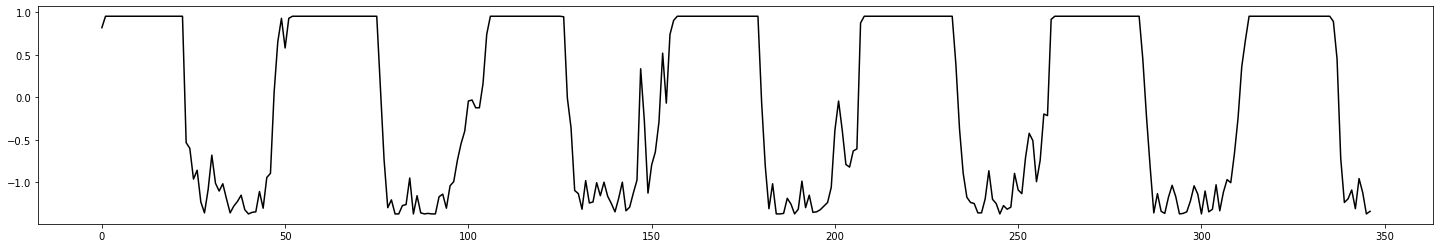

In [ ]:
plt.figure(figsize=(25, 4))
plt.plot(y_extents.flatten(), c='k')

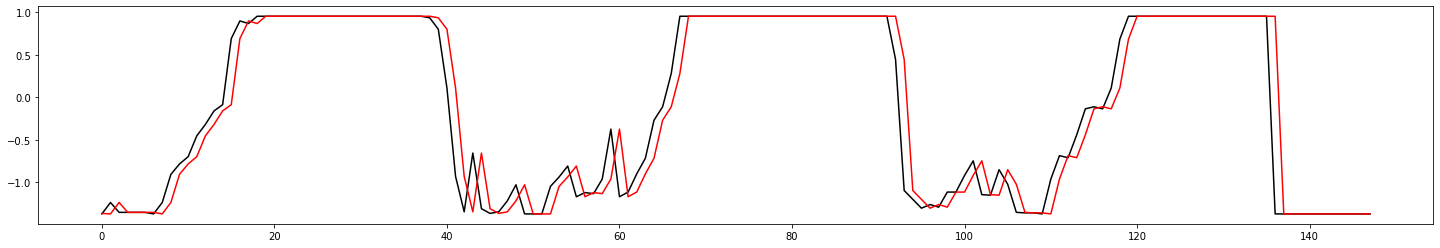

In [ ]:
plt.figure(figsize=(25, 4))
plt.plot(y_extents_test.flatten(), c='k')
plt.plot(pred_persistence, c='r')

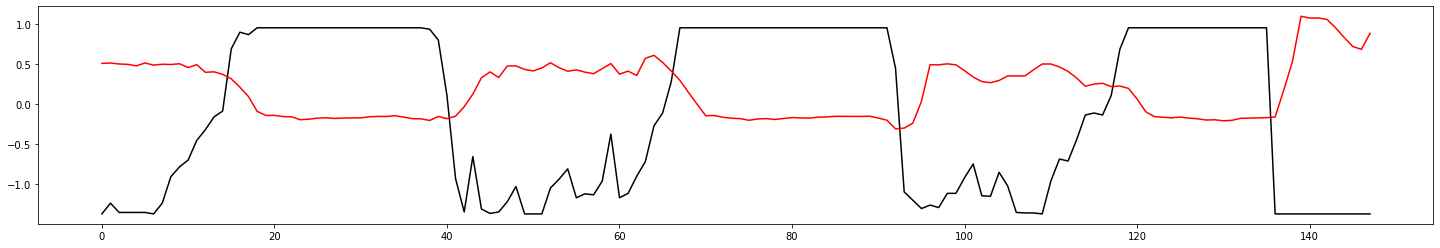

In [ ]:
plt.figure(figsize=(25, 4))
plt.plot(y_extents_test.flatten(), c='k')
plt.plot(pred, c='r')

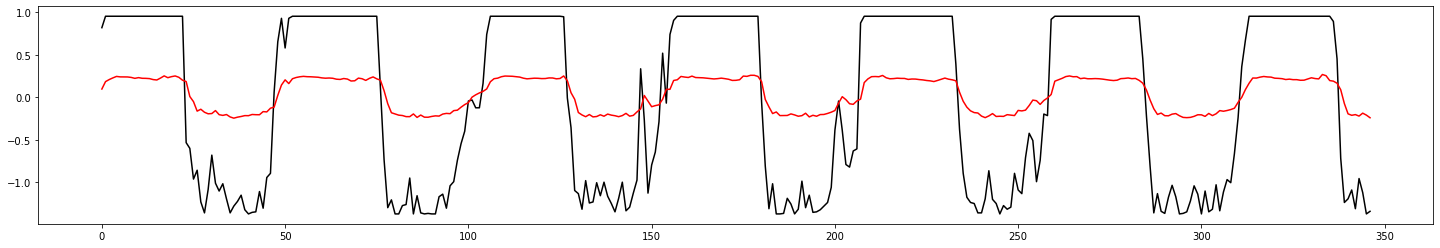

In [ ]:
plt.figure(figsize=(25, 4))
plt.plot(y_extents.flatten(), c='k')
plt.plot(pred_train, c='r')

In [ ]:
reseasonalize = False
if reseasonalize:
    y_extents_reseasonalized = (xr.DataArray(extent_scaler.inverse_transform(y_extents).flatten(), coords={'time': dates_train[num_timesteps + 1:-1]}).groupby('time.month') + climatologies).values
    y_extents_test_reseasonalized = (xr.DataArray(extent_scaler.inverse_transform(y_extents_test).flatten(), coords={'time': dates_test[num_timesteps + 1:-1]}).groupby('time.month') + climatologies).values
    pred_train_reseasonalized = (xr.DataArray(extent_scaler.inverse_transform(pred_train).flatten(), coords={'time': dates_train[num_timesteps + 1:-1]}).groupby('time.month') + climatologies).values
    pred_reseasonalized = (xr.DataArray(extent_scaler.inverse_transform(pred).flatten(), coords={'time': dates_test[num_timesteps + 1:-1]}).groupby('time.month') + climatologies).values

    p = figure(width=1300, height=250, tools=['xpan', 'xwheel_zoom'])
    p.line(range(len(y_extents)), y_extents_reseasonalized, line_color='black')
    p.line(range(len(pred_train)), pred_train_reseasonalized, line_color='orange')

    start_i = len(y_extents)

    p.line(range(start_i, start_i + len(y_extents_test)), y_extents_test_reseasonalized, line_color='black')
    p.line(range(start_i, start_i + len(y_extents_test)), pred_reseasonalized, line_color='red')

    show(p)
else:
    p = figure(width=1300, height=250, tools=['xpan', 'xwheel_zoom'])
    p.line(range(len(y_extents)), y_extents.flatten(), line_color='black')
    p.line(range(len(pred_train)), pred_train.flatten(), line_color='orange')

    start_i = len(y_extents)

    p.line(range(start_i, start_i + len(y_extents_test)), y_extents_test.flatten(), line_color='black')
    p.line(range(start_i, start_i + len(y_extents_test)), pred.flatten(), line_color='red')

    show(p)

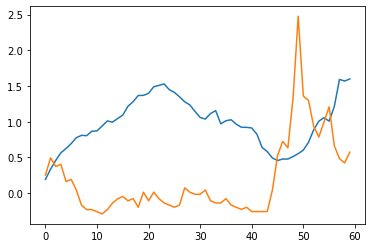

In [ ]:
offset = 360
prediction_timesteps = 60

step_input = [test_X_tight[offset:offset + 1], X_extents_test[offset:offset + 1]]
out = []
for i in range(offset, prediction_timesteps + offset): 
    extent_prediction = model.predict(step_input)
    step_input = [test_X_tight[i + 1:i + 2], extent_prediction]
    out.append(extent_prediction)

out = np.array(out).flatten()

plt.plot(out)
plt.plot(y_extents_test[offset:offset + prediction_timesteps])

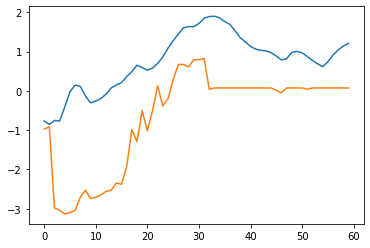

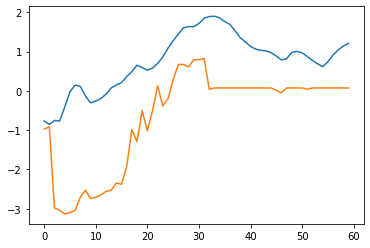

In [ ]:
plt.plot(out)
plt.plot(y_extents_test[offset:offset + prediction_timesteps])

In [ ]:
train_X_flat = train_X[:, :, 30:54, 2:22].mean(axis=(2, 3))
test_X_flat = test_X[:, :, 30:54, 2:22].mean(axis=(2, 3))

In [ ]:
inp = layers.Input(shape=(num_timesteps, 1))
x = layers.LSTM(64, return_sequences=True)(inp)
x = layers.LSTM(32, return_sequences=True)(x)
x = layers.LSTM(1, return_sequences=False)(x)

model = keras.models.Model(inp, x)
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 30, 1)]           0         
                                                                 
 lstm_6 (LSTM)               (None, 30, 64)            16896     
                                                                 
 lstm_7 (LSTM)               (None, 30, 32)            12416     
                                                                 
 lstm_8 (LSTM)               (None, 1)                 136       
                                                                 
Total params: 29,448
Trainable params: 29,448
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Define some callbacks to improve training.
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

# Define modifiable training hyperparameters.
epochs = 100
batch_size = 100

# Fit the model to the training data.
model.fit(
    X_extents,
    y_extents,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_extents_test, y_extents_test),
    callbacks=[early_stopping, reduce_lr],
)

Epoch 1/100
25/25 [==============================] - 3s 37ms/step - loss: 0.9135 - val_loss: 2.2068 - lr: 0.0010
Epoch 2/100
25/25 [==============================] - 1s 24ms/step - loss: 0.8184 - val_loss: 1.9232 - lr: 0.0010
Epoch 3/100
25/25 [==============================] - 1s 24ms/step - loss: 0.7286 - val_loss: 1.7947 - lr: 0.0010
Epoch 4/100
25/25 [==============================] - 1s 27ms/step - loss: 0.6655 - val_loss: 1.7374 - lr: 0.0010
Epoch 5/100
25/25 [==============================] - 1s 26ms/step - loss: 0.6280 - val_loss: 1.7066 - lr: 0.0010
Epoch 6/100
25/25 [==============================] - 1s 27ms/step - loss: 0.6143 - val_loss: 1.6803 - lr: 0.0010
Epoch 7/100
25/25 [==============================] - 1s 31ms/step - loss: 0.5985 - val_loss: 1.6699 - lr: 0.0010
Epoch 8/100
25/25 [==============================] - 1s 28ms/step - loss: 0.5847 - val_loss: 1.6517 - lr: 0.0010
Epoch 9/100
25/25 [==============================] - 1s 27ms/step - loss: 0.5635 - val_loss: 1.6

In [ ]:
pred = model.predict(X_extents_test)
pred_train = model.predict(X_extents)

In [ ]:
reseasonalize = False
if reseasonalize:
    y_extents_reseasonalized = (xr.DataArray(extent_scaler.inverse_transform(y_extents).flatten(), coords={'time': dates_train[num_timesteps + 1:-1]}).groupby('time.month') + climatologies).values
    y_extents_test_reseasonalized = (xr.DataArray(extent_scaler.inverse_transform(y_extents_test).flatten(), coords={'time': dates_test[num_timesteps + 1:-1]}).groupby('time.month') + climatologies).values
    pred_train_reseasonalized = (xr.DataArray(extent_scaler.inverse_transform(pred_train).flatten(), coords={'time': dates_train[num_timesteps + 1:-1]}).groupby('time.month') + climatologies).values
    pred_reseasonalized = (xr.DataArray(extent_scaler.inverse_transform(pred).flatten(), coords={'time': dates_test[num_timesteps + 1:-1]}).groupby('time.month') + climatologies).values

    p = figure(width=1300, height=250, tools=['xpan', 'xwheel_zoom'])
    p.line(range(len(y_extents)), y_extents_reseasonalized, line_color='black')
    p.line(range(len(pred_train)), pred_train_reseasonalized, line_color='orange')

    start_i = len(y_extents)

    p.line(range(start_i, start_i + len(y_extents_test)), y_extents_test_reseasonalized, line_color='black')
    p.line(range(start_i, start_i + len(y_extents_test)), pred_reseasonalized, line_color='red')

    show(p)
else:
    p = figure(width=1300, height=250, tools=['xpan', 'xwheel_zoom'])
    p.line(range(len(y_extents)), y_extents.flatten(), line_color='black')
    p.line(range(len(pred_train)), pred_train.flatten(), line_color='orange')

    start_i = len(y_extents)

    p.line(range(start_i, start_i + len(y_extents_test)), y_extents_test.flatten(), line_color='black')
    p.line(range(start_i, start_i + len(y_extents_test)), pred.flatten(), line_color='red')

    show(p)

## MISC

In [ ]:
# Single timestep
num_timesteps = 3
def create_timesteps(arr, num_timesteps=3):
    timesteps = [arr[:-(num_timesteps - 1)]]
    
    for i in range(1, num_timesteps - 1):
        timesteps.append(arr[i:-((num_timesteps-1)-i)])
                 
    timesteps.append(arr[(num_timesteps - 1):])
    return np.array(timesteps)

train_X = np.transpose(train_array, axes=[1, 2, 3, 0])
train_X = create_timesteps(train_X, num_timesteps + 1)
train_X = np.transpose(train_X, axes=[1, 0, 2, 3, 4])

test_X = np.transpose(test_array, axes=[1, 2, 3, 0])
test_X = create_timesteps(test_X, num_timesteps + 1)
test_X = np.transpose(test_X, axes=[1, 0, 2, 3, 4])

# Split x and y
train_Y = np.expand_dims(train_X[:, -1, :, :, 0], [1, -1])
train_X = train_X[:, :-1, :, :]

test_Y = np.expand_dims(test_X[:, -1, :, :, 0], [1, -1])
test_X = test_X[:, :-1, :, :]

print(f'{train_X.shape=}')
print(f'{train_Y.shape=}')
print(f'{test_X.shape=}')
print(f'{test_Y.shape=}')

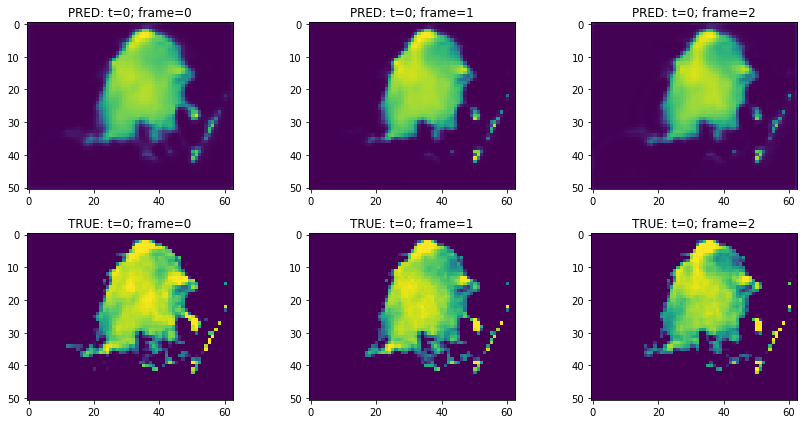

In [ ]:
pred = model.predict(np.nan_to_num(train_X[:10, :1]))

pred_timesteps = pred.shape[1]
num_timesteps = 5
fig, axs = plt.subplots(num_timesteps, pred_timesteps, figsize=(pred_timesteps * 4, num_timesteps * 3))

for i in range(num_timesteps):
    for j in range(pred_timesteps):
        axs[i][j].imshow(pred[i, j, :, :, 0])
        axs[i][j].set_title(f't={i}; frame={j}')
        
plt.tight_layout()